# Geodesic Distance as new Relation

In [1]:
import sys
from pprint import pprint
#pprint(sys.path)

In [2]:
import sys
sys.path.append('../')

import sys
from pprint import pprint
#pprint(sys.path)

In [3]:
from typing import Union, Callable, Optional
import warnings
import torch
import torch.nn.functional as F
import pynndescent
from scipy.spatial import distance


from paradime import relationdata
from paradime import relations
from paradime import transforms
from paradime import dr
from paradime.types import BinaryTensorFun, TensorLike
Transform = Union[transforms.RelationTransform, list[transforms.RelationTransform]]
from paradime import utils

In [4]:
import paradime
from matplotlib import pyplot as plt
import numpy as np

## Class for Geodesic Distances

In [5]:
class GeodesicDist(paradime.relations.Relations):
    """Geodesic distances between data points.

    Args:
        metric: The distance metric to be used.
        transform: A single :class:`paradime.transforms.Transform` or list of
            :class:`paradime.transforms.Transform` instances to be applied to
            the relations.
        keep_result: Specifies whether or not to keep previously
            calculated distances, rather than computing new ones.
        data_key: The key to access the data for which to compute relations.
        verbose: Verbosity toggle.

    Attributes:
        relations: A :class:`paradime.relationdata.RelationData` instance
            containing the (possibly transformed) pairwise distances.
            Available only after calling :meth:`compute_relations`.
    """

    def __init__(
        self,
        metric: Optional[Union[Callable, str]] = None,
        transform: Optional[Transform] = None,
        keep_result=True,
        data_key: str = "main",
        verbose: bool = False,
    ):

        super().__init__(
            transform=transform,
            data_key=data_key,
        )

        self.metric = metric
        self.keep_result = keep_result
        self.verbose = verbose
    
    def compute_geodesic_distances(self, 
        X, 
        n_neighbors=5, 
        radius=None,
        path_method="auto", 
        neighbors_algorithm="auto", 
        n_jobs=None, 
        metric="minkowski", 
        p=2, 
        metric_params=None):

        import warnings
        import numpy as np
        from scipy.sparse import issparse
        from scipy.sparse.csgraph import shortest_path
        from scipy.sparse.csgraph import connected_components

        from sklearn.neighbors import NearestNeighbors, kneighbors_graph
        from sklearn.neighbors import radius_neighbors_graph
        from sklearn.utils.graph import _fix_connected_components

        # first step: find the nearest neighbours
        nbrs_ = NearestNeighbors(
            n_neighbors=n_neighbors,
            radius=radius,
            algorithm=neighbors_algorithm,
            metric=metric,
            p=p,
            metric_params=metric_params,
            n_jobs=n_jobs,
        )
        nbrs_.fit(X)

        # two options: 
        # option 1: choose the number of neighbours
        if n_neighbors is not None:
            nbg = kneighbors_graph(
                nbrs_,
                n_neighbors,
                metric=metric,
                p=p,
                metric_params=metric_params,
                mode="distance",
                n_jobs=n_jobs,
            )
        
        # option 2: choose a radius
        else:
            nbg = radius_neighbors_graph(
                nbrs_,
                radius=radius,
                metric=metric,
                p=p,
                metric_params=metric_params,
                mode="distance",
                n_jobs=n_jobs,
            )

        # Compute the number of connected components, and connect the different
        # components to be able to compute a shortest path between all pairs
        # of samples in the graph.
        n_connected_components, labels = connected_components(nbg)
        if n_connected_components > 1:
            if metric == "precomputed" and issparse(X):
                raise RuntimeError(
                    "The number of connected components of the neighbors graph"
                    f" is {n_connected_components} > 1. The graph cannot be "
                    "completed with metric='precomputed', and Isomap cannot be"
                    "fitted. Increase the number of neighbors to avoid this "
                    "issue, or precompute the full distance matrix instead "
                    "of passing a sparse neighbors graph."
                )
            warnings.warn(
                "The number of connected components of the neighbors graph "
                f"is {n_connected_components} > 1. Completing the graph to fit"
                " Isomap might be slow. Increase the number of neighbors to "
                "avoid this issue.",
                stacklevel=2,
            )

            # use array validated by NearestNeighbors
            nbg = _fix_connected_components(
                X=nbrs_._fit_X,
                graph=nbg,
                n_connected_components=n_connected_components,
                component_labels=labels,
                mode="distance",
                metric=nbrs_.effective_metric_,
                **nbrs_.effective_metric_params_,
            )
        
        # compute the distance matrix by using the shortest path
        dist_matrix_ = shortest_path(nbg, method=path_method, directed=False)

        return dist_matrix_

    def compute_relations(
        self, X: Optional[TensorLike] = None, **kwargs
    ) -> relationdata.RelationData:
        """Calculates the geodesic distances.#

        Args:
            X: Input data tensor with one sample per row.

        Returns:
            A :class:`paradime.relationdata.RelationData` instance containing
            the (possibly transformed) geodesic distances.
        """
        
        if X is None:
            raise ValueError("Missing input for non-precomputed relations.")

        X = utils.convert.to_numpy(X)

        if self._relations is None or not self.keep_result:
            if self.verbose:
                utils.logging.log("Calculating pairwise distances.")
            self.relations = self._transform(
                relationdata.relation_factory(
                    self.compute_geodesic_distances(X)
                ))


        elif self.verbose:
            utils.logging.log("Using previously calculated distances.")

        return self.relations

### Class for paiwise distances (for testing and comparing)

In [6]:
class PDist(paradime.relations.Relations):
    """Full pairwise distances between data points.

    Args:
        metric: The distance metric to be used.
        transform: A single :class:`paradime.transforms.Transform` or list of
            :class:`paradime.transforms.Transform` instances to be applied to
            the relations.
        keep_result: Specifies whether or not to keep previously
            calculated distances, rather than computing new ones.
        data_key: The key to access the data for which to compute relations.
        verbose: Verbosity toggle.

    Attributes:
        relations: A :class:`paradime.relationdata.RelationData` instance
            containing the (possibly transformed) pairwise distances.
            Available only after calling :meth:`compute_relations`.
    """

    def __init__(
        self,
        metric: Optional[Union[Callable, str]] = None,
        transform: Optional[Transform] = None,
        keep_result=True,
        data_key: str = "main",
        verbose: bool = False,
    ):

        if metric is None:
            metric = "euclidean"

        super().__init__(
            transform=transform,
            data_key=data_key,
        )

        self.metric = metric
        self.keep_result = keep_result
        self.verbose = verbose

    def compute_relations(
        self, X: Optional[TensorLike] = None, **kwargs
    ) -> relationdata.RelationData:
        """Calculates the pairwise distances.

        Args:
            X: Input data tensor with one sample per row.

        Returns:
            A :class:`paradime.relationdata.RelationData` instance containing
            the (possibly transformed) pairwise distances.
        """

        if X is None:
            raise ValueError("Missing input for non-precomputed relations.")

        X = utils.convert.to_numpy(X)

        if self._relations is None or not self.keep_result:
            if self.verbose:
                utils.logging.log("Calculating pairwise distances.")
            self.relations = self._transform(
                relationdata.relation_factory(
                    distance.pdist(X, metric=self.metric)
                )
            )
        elif self.verbose:
            utils.logging.log("Using previously calculated distances.")

        return self.relations

## Test it on an example

In [7]:
import sklearn.datasets
diabetes = sklearn.datasets.load_diabetes()
data = diabetes['data']

## Example with MDS (pairwise distances)

In [17]:
pca = sklearn.decomposition.PCA().fit(data)

In [18]:
pd_pca = paradime.dr.ParametricDR(
    model=torch.nn.Linear(10,10,bias=False),
    verbose=True,
    losses=paradime.loss.PositionLoss(
        position_key="pca",
        embedding_method="forward",
    )
)

pd_pca.add_training_phase(
    epochs=20,
    batch_size=50,
    report_interval=2,
)

pd_pca.train({
    "main": data,
    "pca": pca.transform(data),
})

2022-12-10 21:58:15,772: Initializing training dataset.
2022-12-10 21:58:15,774: Beginning training phase 'None'.
2022-12-10 21:58:15,785: Loss after epoch 0: 0.021320768049918115
2022-12-10 21:58:15,810: Loss after epoch 2: 0.008276781358290464
2022-12-10 21:58:15,835: Loss after epoch 4: 0.0034246750292368233
2022-12-10 21:58:15,863: Loss after epoch 6: 0.0014823668461758643
2022-12-10 21:58:15,884: Loss after epoch 8: 0.0006689928886771668
2022-12-10 21:58:15,907: Loss after epoch 10: 0.000330467115418287
2022-12-10 21:58:15,935: Loss after epoch 12: 0.000180217841261765
2022-12-10 21:58:15,964: Loss after epoch 14: 0.00011027065102098277
2022-12-10 21:58:15,989: Loss after epoch 16: 7.27854521755944e-05
2022-12-10 21:58:16,014: Loss after epoch 18: 5.2432590564421844e-05


In [19]:
def mse(a, b):
    return torch.sum((a - b) ** 2)


pd_mds = paradime.dr.ParametricDR(
    model=torch.nn.Linear(10, 2, bias=False),
    global_relations=PDist(
        transform=[
            paradime.transforms.ToSquareTensor(),
            paradime.transforms.Functional(lambda x: x.float()),
        ]
    ),
    batch_relations=paradime.relations.DifferentiablePDist(
        transform=paradime.transforms.ToSquareTensor()
    ),
    losses=paradime.loss.RelationLoss(
        loss_function=mse,
        embedding_method="forward",
        normalize_sub=False,
    ),
    verbose=True,
)

pd_mds.add_training_phase(
    epochs=500,
    batch_size=len(data),
    learning_rate=0.01,
    report_interval=50,
)

pd_mds.train(data)

2022-12-10 21:58:18,590: Initializing training dataset.
2022-12-10 21:58:18,591: Computing global relations 'rel'.
2022-12-10 21:58:18,592: Calculating pairwise distances.
2022-12-10 21:58:18,597: Beginning training phase 'None'.
2022-12-10 21:58:18,614: Loss after epoch 0: 5952.13818359375
2022-12-10 21:58:19,444: Loss after epoch 50: 1159.3330078125
2022-12-10 21:58:20,366: Loss after epoch 100: 780.3225708007812
2022-12-10 21:58:21,118: Loss after epoch 150: 718.2045288085938
2022-12-10 21:58:21,799: Loss after epoch 200: 696.2609252929688
2022-12-10 21:58:22,475: Loss after epoch 250: 678.802734375
2022-12-10 21:58:23,131: Loss after epoch 300: 662.897705078125
2022-12-10 21:58:23,863: Loss after epoch 350: 649.1461791992188
2022-12-10 21:58:24,535: Loss after epoch 400: 638.6422119140625
2022-12-10 21:58:25,202: Loss after epoch 450: 631.7606201171875


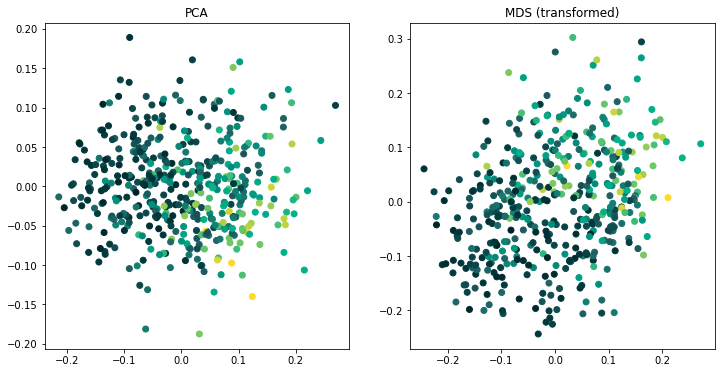

In [20]:
mds_matrix = pd_mds.model.weight.detach().numpy()
cmap = paradime.utils.plotting.get_colormap()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(
    *np.stack([np.dot(pca.components_[:2], i) for i in data]).T,
    c=diabetes.target,
    cmap=cmap,
)
ax1.set_title("PCA")
ax2.scatter(
    *np.stack([np.dot(mds_matrix, i) for i in data]).T,
    c=diabetes.target,
    cmap=cmap,
)
ax2.set_title("MDS (transformed)");

## Example for Isomap (geodesic distances)

In [12]:
# for isomap
def mse(a, b):
    return torch.sum((a - b) ** 2)


pd_isomap = paradime.dr.ParametricDR(
    model=torch.nn.Linear(10, 2, bias=False),
    global_relations=GeodesicDist(
        transform=[
            paradime.transforms.ToSquareTensor(),
            paradime.transforms.Functional(lambda x: x.float()),
        ]
    ),
    batch_relations=paradime.relations.DifferentiablePDist(
        transform=paradime.transforms.ToSquareTensor()
    ),
    losses=paradime.loss.RelationLoss(
        loss_function=mse,
        embedding_method="forward",
        normalize_sub=False,
    ),
    verbose=True,
)

pd_isomap.add_training_phase(
    epochs=500,
    batch_size=len(data),
    learning_rate=0.01,
    report_interval=50,
)

pd_isomap.train(data)

2022-12-10 21:56:50,578: Initializing training dataset.
2022-12-10 21:56:50,578: Computing global relations 'rel'.
2022-12-10 21:56:50,579: Calculating pairwise distances.
2022-12-10 21:56:50,669: Beginning training phase 'None'.
2022-12-10 21:56:50,687: Loss after epoch 0: 31319.38671875
2022-12-10 21:56:51,573: Loss after epoch 50: 10324.173828125
2022-12-10 21:56:52,389: Loss after epoch 100: 8441.9541015625
2022-12-10 21:56:53,270: Loss after epoch 150: 7524.3798828125
2022-12-10 21:56:54,140: Loss after epoch 200: 6081.38427734375
2022-12-10 21:56:54,951: Loss after epoch 250: 4682.3251953125
2022-12-10 21:56:55,813: Loss after epoch 300: 3738.24267578125
2022-12-10 21:56:56,687: Loss after epoch 350: 3164.529052734375
2022-12-10 21:56:57,518: Loss after epoch 400: 2803.836181640625
2022-12-10 21:56:58,311: Loss after epoch 450: 2563.63916015625


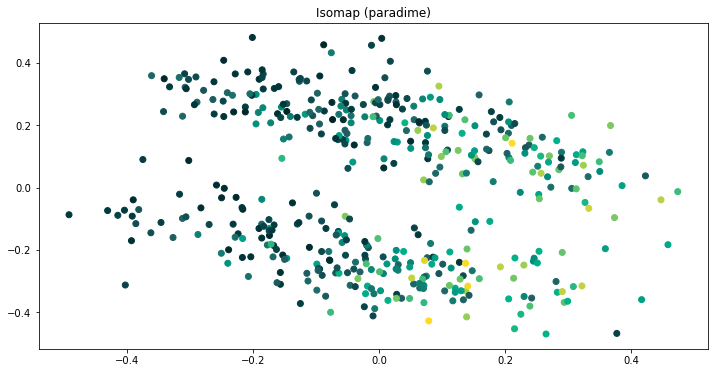

In [22]:
isomap_matrix = pd_isomap.model.weight.detach().numpy()
cmap = paradime.utils.plotting.get_colormap()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.scatter(
    *np.stack([np.dot(isomap_matrix, i) for i in data]).T,
    c=diabetes.target,
    cmap=cmap,
)
ax.set_title("Isomap (paradime)");

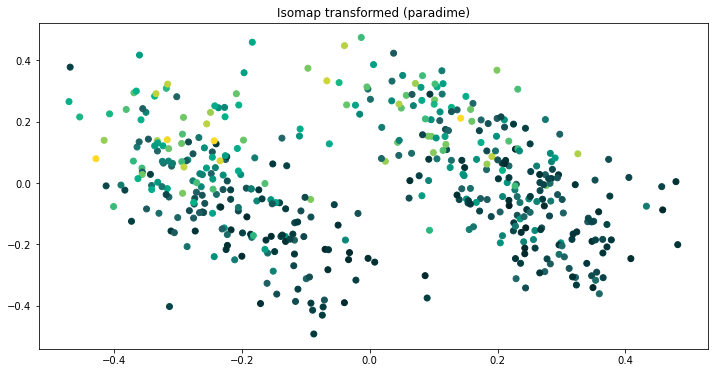

In [14]:
isomap_matrix_tf = isomap_matrix[::-1]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.scatter(
    *np.stack([np.dot(isomap_matrix_tf, i) for i in data]).T,
    c=diabetes.target,
    cmap=cmap,
)
ax.set_title("Isomap transformed (paradime)");

## Compare with the Isomap of sklearn

In [15]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(data)

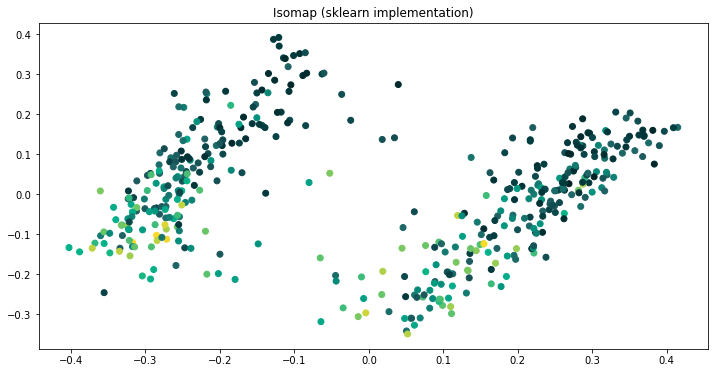

In [21]:
plt.figure(figsize=(12, 6))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=diabetes.target, cmap=paradime.utils.plotting.get_colormap())
plt.title("Isomap (sklearn implementation)")
plt.show()